In [33]:
import pandas as pd
%matplotlib inline
from collections import Counter
#from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import random
import re
import operator


# source: https://www.kaggle.com/datasnaek/youtube-new/data

In [8]:
trending = pd.DataFrame.from_csv('USvideos_1.csv')
trending_UK = pd.DataFrame.from_csv("GBvideos.csv")
trending_CA = pd.DataFrame.from_csv("CAvideos.csv")

categories = pd.DataFrame.from_csv("categories.csv",index_col=None)
trending= trending.merge(categories,on="category_id")
trending_UK = trending_UK.merge(categories,on="category_id")
trending_CA = trending_CA.merge(categories,on="category_id")

In [9]:
# Voeg ratios toe
trending['like_view_ratio'] = trending.likes / trending.views
trending['dislike_view_ratio'] = trending.dislikes / trending.views
trending["like_dislike_ratio"] = trending.likes / trending.dislikes

In [10]:
# regelt timecodes
# we moeten tijden indelen in blokken van een uur dus 23:30 gaat in het blok van 00:00 en 04:45 in 05:00
times = [[int(y[0]),int(y[1])] for y in [x.split("T")[1][:-8].split(":") for x in trending.publish_time]]
timecodes = [] 
for hour, minutes in times:
    if minutes==0:
        timecodes.append(hour)
    else:
        if hour != 23:
            timecodes.append(hour+1)
        else:
            timecodes.append(0)
trending["timecode"]= pd.Series(timecodes,index=trending.index)

In [12]:
publish_dates = []
for x in trending.publish_time:
    temp = x.split("T")[0].replace("-",".")
    publish_dates.append( temp[2:5]+str(int(temp[-2:])+1)+temp[-6:-3])
trending["publish_date"]=publish_dates


In [20]:
# calculates the time until a video becomes trending
originalTimes = trending[["trending_date","publish_date","timecode"]]
time_until_trending= []
for x in originalTimes.iterrows():
    trendDate = x[1][0].split(".")
    publDate  = x[1][1].split(".")
    timeCode  = int(x[1][2])
    hours  = abs(int(trendDate[1])-int(publDate[1]))*24
    months = abs(int(trendDate[2])-int(publDate[2]))*720
    total = timeCode+hours+months
    time_until_trending.append(total)
trending["time_until_trending"]=time_until_trending

#preparation for wordclouds
contro = trending[trending.like_dislike_ratio < 1].title.values

In [21]:
def color_func_red(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 50%%, %d%%)" % random.randint(40, 80)

def color_func_green(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(100, 50%%, %d%%)" % random.randint(40, 80)

def color_func_blue(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(200, 50%%, %d%%)" % random.randint(40, 80)

In [ ]:
def gen_word_cloud(data, color, collo):
    
    # Kleuren bepalen
    if color == 1:
        func = color_func_red
    elif color == 2:
        func = color_func_green
    else:
        func = color_func_blue
    
    text = " ".join([re.sub(r"[!.\(\)\[\],\´\';\'\-:\'\"]", "", str(x).lower()) for x in data])

    wordcloud = WordCloud(width=2000, height=1000, relative_scaling = 1, max_words=40, collocations=collo, regexp=r"\w[\S']+",
                          stopwords = stopwords.words('english') # set or space-separated string
                          ).generate(text)
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud.recolor(color_func=func, random_state=3),
               interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [32]:
def stripTitle(titles,country):
    result= []
    stop = stopwords.words("english")
    for x in titles:
        temp = re.sub(r"[!.\(\)\[\],\´\';\'\-:\'\"\|\/\*\?\&]", "", str(x).lower())
        temp = re.sub(r" {2,}", " ", temp)
        
        for y in temp.split(" "):
            if y not in stop and re.fullmatch(r"\D+",y):
                result.append(y)
    return result

def stripTitlesToDict(titles,country):
    result= stripTitle(titles,country)
    resultDict=Counter(result)            
    words = pd.DataFrame.from_dict(resultDict,orient='index')
    words.columns=[country]
    words[country]=words[country]/len(words[country])
    return words

def stripTitlesCount(titles,country):
    result= stripTitle(titles,country)
    resultDict=Counter(result)
    return resultDict
    

# Hieronder alle tijdelijk uitgecommente code, ivm errors of work in progress

#preparation results code, still needs to be recreated
results=[]
for x in trending.title:
    temp= trending[trending.title==x]
    if len(temp)!=1:
        results.append((max(temp.views)-min(temp.views)/len(temp)))
    else:
        results.append(temp.views.max())
trending["increase_views"]=results

## Welke termen zijn het meest voorkomend in titels van trending video's en verschillen deze termen bij variërende like/dislike ratio’s?

In [24]:
# alles biagrams met negatieve ratio in titels
#gen_word_cloud(contro, 1, True)

In [25]:
# Alle enkele woorden
titles = trending[trending.like_dislike_ratio > 1].title.values
#gen_word_cloud(titles, 2, False)

In [26]:
# Alle biagrams met hoge ratio
#gen_word_cloud(titles, 2, True)

In [34]:
titles = stripTitlesCount(trending.title.values, "US")
titleslike = stripTitlesCount(trending[trending.like_view_ratio > 0.10].title.values, "US")
titlesdislike = stripTitlesCount(trending[trending.dislike_view_ratio > 0.10].title.values, "US")

alles = sorted(titles.items(), key=operator.itemgetter(1), reverse=True)
like = sorted(titleslike.items(), key=operator.itemgetter(1), reverse=True)
dislike = sorted(titlesdislike.items(), key=operator.itemgetter(1), reverse=True)

print(alles[:20])
print(like[:20])
print(dislike[:20])

[('official', 2097), ('video', 1389), ('trailer', 1104), ('ft', 697), ('new', 693), ('music', 569), ('audio', 561), ('live', 556), ('hd', 539), ('vs', 538), ('day', 492), ('makeup', 462), ('first', 441), ('christmas', 435), ('star', 430), ('best', 401), ('make', 393), ('super', 392), ('black', 391), ('full', 361)]
[('official', 87), ('video', 76), ('mv', 55), ('bts', 54), ('audio', 40), ('live', 40), ('ft', 32), ('day', 27), ('camila', 27), ('cabello', 26), ('makeup', 25), ('cover', 25), ('feat', 24), ('lyric', 24), ('holiday', 23), ('dodie', 23), ('things', 22), ('music', 22), ('trailer', 22), ('beauty', 21)]
[('fcc', 7), ('repeals', 4), ('net', 4), ('neutrality', 4), ('rules', 4), ('psa', 3), ('chairman', 3), ('ajit', 3), ('pai', 3)]


## Welke termen zijn het meest voorkomend in beschrijvingen van trending video's en verschillen deze termen bij variërende like/dislike ratio’s?


In [27]:
# Alle beschrijvingen bekijken, enkele woorden.
description = trending.description.values
#gen_word_cloud(description, 3, False)

In [39]:
descriptions = stripTitlesCount(description, "US")
descriptionlike = stripTitlesCount(trending[trending.like_view_ratio > 0.10].description.values, "US")
descriptiondislike = stripTitlesCount(trending[trending.dislike_view_ratio > 0.10].description.values, "US")

alles = sorted(descriptions.items(), key=operator.itemgetter(1), reverse=True)
like = sorted(descriptionlike.items(), key=operator.itemgetter(1), reverse=True)
dislike = sorted(descriptiondislike.items(), key=operator.itemgetter(1), reverse=True)

print(alles[:20])
print(like[:20])
print(dislike[:20])

[('_', 15177), ('video', 11710), ('us', 9325), ('new', 8104), ('videos', 7644), ('music', 6920), ('channel', 6661), ('twitter', 6385), ('get', 5979), ('news', 5851), ('facebook', 5694), ('subscribe', 5661), ('instagram', 5493), ('show', 5219), ('like', 5188), ('youtube', 5179), ('make', 4386), ('one', 4162), ('watch', 4024), ('►', 3893)]
[('video', 497), ('music', 378), ('new', 320), ('channel', 286), ('code', 214), ('»', 184), ('get', 178), ('use', 174), ('love', 163), ('book', 162), ('instagram', 143), ('know', 143), ('make', 136), ('us', 136), ('song', 134), ('want', 134), ('links', 132), ('album', 130), ('one', 126), ('like', 124)]
[('—', 8), ('internet', 7), ('subscribe', 7), ('news', 6), ('federal', 4), ('regulators', 4), ('vote', 4), ('allow', 4), ('providers', 4), ('speed', 4), ('service', 4), ('apps', 4), ('websites', 4), ('block', 4), ('slow', 4), ('others', 4), ('decision', 4), ('repealing', 4), ('landmark', 4), ('obamaera', 4)]


## Is er een verband tussen de ratio van het aantal likes en het aantal views?


# MOET ANDER PLOTJE WORDEN

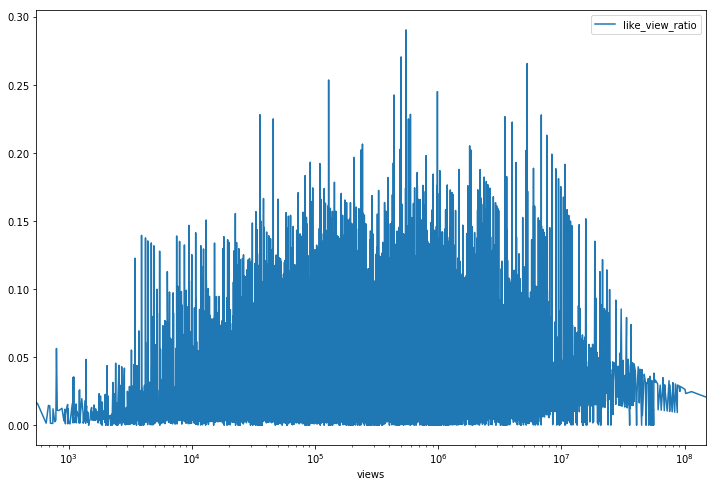

In [28]:
# Ratio likes ten opzichte van views.
trending.sort_values(by='views').plot(x='views', y="like_view_ratio", figsize=(12,8), logx=True)

## Is er een verband tussen de ratio van het aantal dislikes en het aantal views?


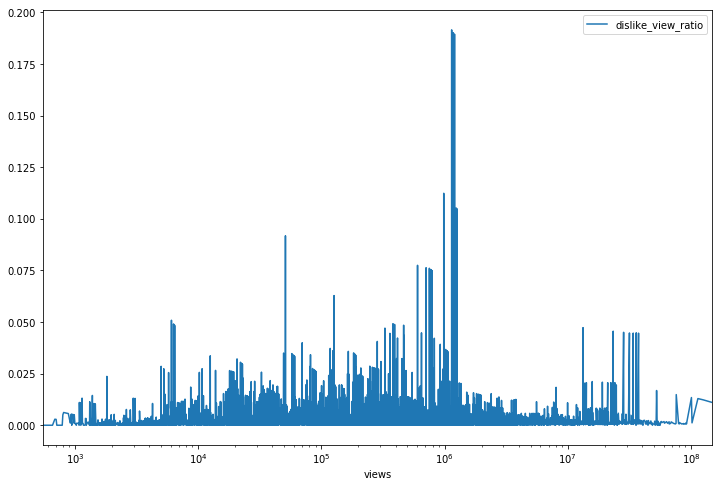

In [40]:
# Ratio dislikes ten opzichte van views.
trending.sort_values(by='views').plot(x='views', y="dislike_view_ratio", figsize=(12,8), logx=True)

## Zijn er verschillen in titels tussen US, GB en CA?

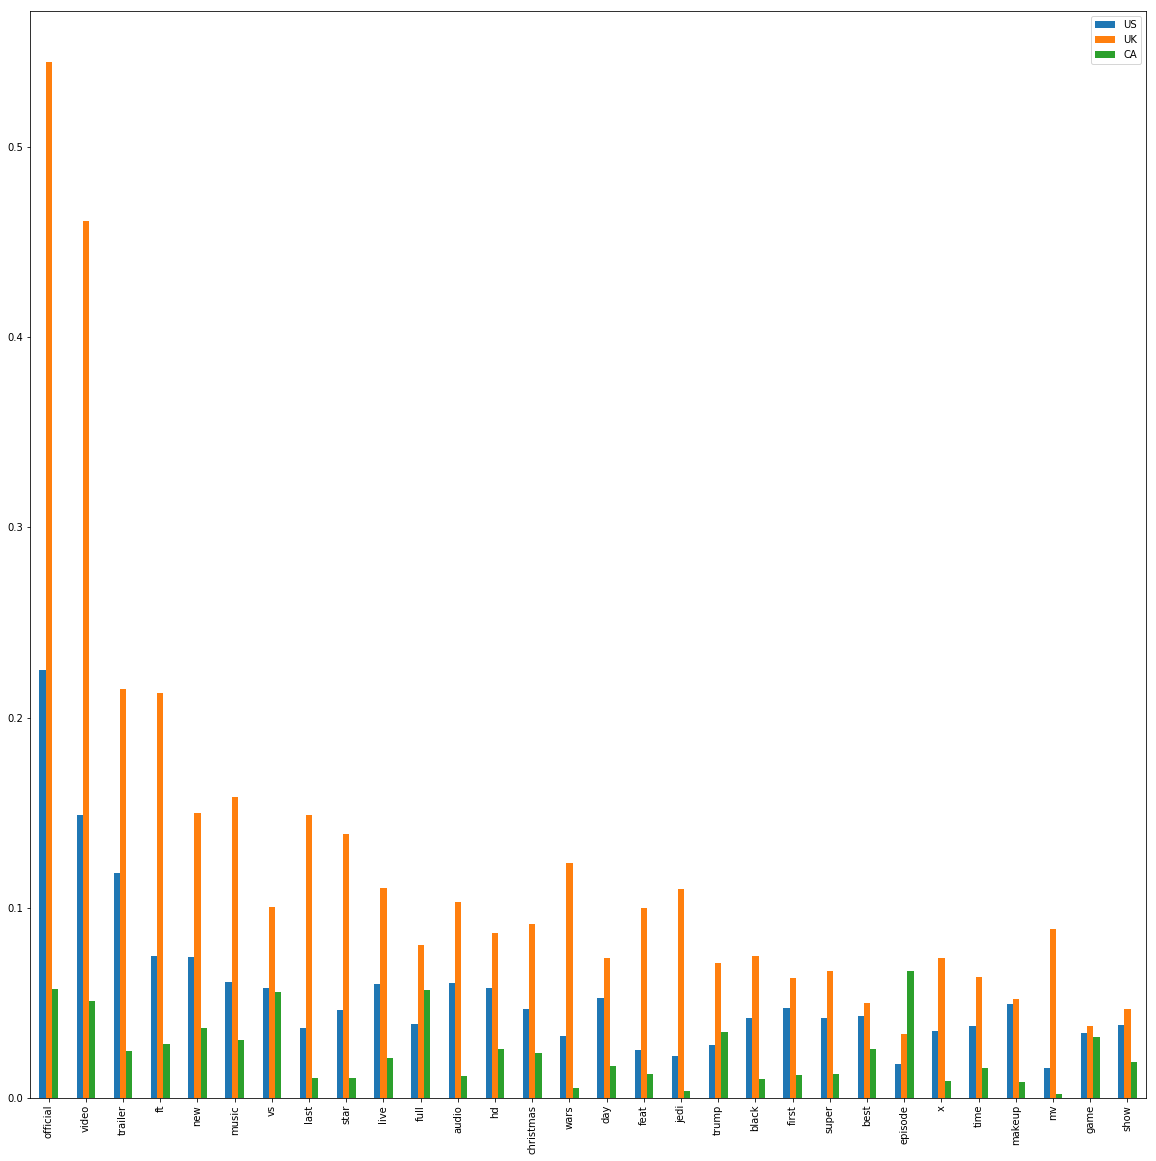

In [43]:

US=stripTitlesToDict(trending.title.values,"US")
CA=stripTitlesToDict(trending_CA.title.values,"CA")
UK=stripTitlesToDict(trending_UK.title.values,"UK")
US= US.join(CA).join(UK)
US["total"]=US.UK+US.US+US.CA
US.sort_values("total",ascending=False)[["US","UK","CA"]][:30].plot(kind="bar",figsize=(20,20))

##  Wat is de gemiddelde toename aan views voor trending video's die meerdere dagen in de trending staan?


In [36]:
#code

##  Wat zijn de meest voorkomende categorieën en hoe verschilt dat bij verschillende like/view ratio’s?

In [37]:
#code

## Is er een verband tussen de publicatie tijd en het aantal views?

In [38]:
# code